In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from bert_lstm import *

In [3]:
# Use GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Available device: {}".format(device))
if use_cuda:
    print(torch.cuda.get_device_name(0))

Available device: cuda:0
NVIDIA GeForce GTX 1070


In [4]:
sample_column_name = "string"
columns_to_keep = ['string', 'label', 'citeStart', 'citeEnd']

train_dataset_file_path = "../../data/raw/train.jsonl"
test_dataset_file_path = "../../data/raw/test.jsonl"

label_to_index = {
    "background": 0,
    "method": 1,
    "result": 2
}

# Load dataset
df_train = load_dataset_raw(train_dataset_file_path, sample_column=sample_column_name, columns_to_keep=columns_to_keep)
df_test = load_dataset_raw(test_dataset_file_path, sample_column=sample_column_name, columns_to_keep=columns_to_keep)

# {'background': 0, 'method': 1, 'result': 2}
unique_labels = df_train['label'].unique()

In [5]:
citation_token = ["<cite>"]

In [6]:
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
# processing the dataset
print("Processing train dataset...")
texts_train, labels_train = process_data_bert(df_train, label_to_index)

print("Processing test dataset...")
texts_test, labels_test = process_data_bert(df_test, label_to_index)

print('Total number of training samples: {}'.format(len(texts_train)))
print('Total number of test samples: {}'.format(len(texts_test)))

Processing train dataset...


100%|██████████| 8240/8240 [00:00<00:00, 22759.96it/s]


Processing test dataset...


100%|██████████| 1857/1857 [00:00<00:00, 22099.77it/s]

Total number of training samples: 8240
Total number of test samples: 1857


In [8]:
# tokenize dataset with bert tokenizer

max_seq_length = 128

tokens_train = bert_tokenizer.batch_encode_plus(
    texts_train,
    max_length = max_seq_length,
    padding=True,
    truncation=True
)

tokens_test = bert_tokenizer.batch_encode_plus(
    texts_test,
    max_length = max_seq_length,
    padding=True,
    truncation=True
)

In [9]:
# generate sequence, mask and labels

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(labels_train)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(labels_test)

In [10]:
# dataset label counts
counts = torch.bincount(train_y)
print(counts)

tensor([4840, 2293, 1107])


In [11]:
# define dataloaders

batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(test_seq, test_mask, test_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [12]:
for X, mask, y in train_dataloader:
    print('X.shape:', X.shape)
    print('mask.shape:', mask.shape)
    print('y.shape:', y.shape)
    break

X.shape: torch.Size([32, 128])
mask.shape: torch.Size([32, 128])
y.shape: torch.Size([32])


In [13]:
# initialize bert lstm model
lstm_model = BertLSTM(bert_model)
lstm_model = lstm_model.to(device)

print(lstm_model)

BertLSTM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [14]:
class_weights = torch.tensor([1 / counts[0].item(), 
                              1 / counts[1].item(), 
                              1 / counts[2].item()]).to(device)

criterion  = nn.CrossEntropyLoss(weight=class_weights) 
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.0005)

In [15]:
num_epochs = 25

results = train(lstm_model, train_dataloader, val_dataloader, 
                optimizer, criterion, num_epochs, device, verbose=True)

Total Training Time (total number of epochs: 25)


100%|██████████| 59/59 [00:13<00:00,  4.43it/s]


saving model checkpoint to bert_lstm.pth
[Epoch 1] loss:	223.698, f1 train: 0.748, f1 test: 0.786 


100%|██████████| 59/59 [00:12<00:00,  4.57it/s]


saving model checkpoint to bert_lstm.pth
[Epoch 2] loss:	206.328, f1 train: 0.781, f1 test: 0.794 


100%|██████████| 59/59 [00:13<00:00,  4.53it/s]


[Epoch 3] loss:	192.947, f1 train: 0.745, f1 test: 0.752 


100%|██████████| 59/59 [00:13<00:00,  4.40it/s]


saving model checkpoint to bert_lstm.pth
[Epoch 4] loss:	187.726, f1 train: 0.820, f1 test: 0.821 


100%|██████████| 59/59 [00:13<00:00,  4.45it/s]


[Epoch 5] loss:	185.337, f1 train: 0.793, f1 test: 0.794 


100%|██████████| 59/59 [00:13<00:00,  4.43it/s]


saving model checkpoint to bert_lstm.pth
[Epoch 6] loss:	174.802, f1 train: 0.829, f1 test: 0.829 


100%|██████████| 59/59 [00:13<00:00,  4.39it/s]


[Epoch 7] loss:	169.730, f1 train: 0.820, f1 test: 0.823 


100%|██████████| 59/59 [00:13<00:00,  4.41it/s]


saving model checkpoint to bert_lstm.pth
[Epoch 8] loss:	163.215, f1 train: 0.844, f1 test: 0.834 


100%|██████████| 59/59 [00:13<00:00,  4.39it/s]


saving model checkpoint to bert_lstm.pth
[Epoch 9] loss:	162.128, f1 train: 0.859, f1 test: 0.844 


100%|██████████| 59/59 [00:13<00:00,  4.39it/s]


[Epoch 10] loss:	156.636, f1 train: 0.862, f1 test: 0.831 


100%|██████████| 59/59 [00:13<00:00,  4.38it/s]


[Epoch 11] loss:	151.479, f1 train: 0.753, f1 test: 0.716 


100%|██████████| 59/59 [00:13<00:00,  4.32it/s]


[Epoch 12] loss:	154.599, f1 train: 0.872, f1 test: 0.833 


100%|██████████| 59/59 [00:13<00:00,  4.39it/s]


[Epoch 13] loss:	144.647, f1 train: 0.796, f1 test: 0.760 


100%|██████████| 59/59 [00:13<00:00,  4.33it/s]


[Epoch 14] loss:	144.635, f1 train: 0.862, f1 test: 0.814 


100%|██████████| 59/59 [00:13<00:00,  4.33it/s]


[Epoch 15] loss:	136.737, f1 train: 0.872, f1 test: 0.810 


100%|██████████| 59/59 [00:13<00:00,  4.30it/s]


[Epoch 16] loss:	135.912, f1 train: 0.891, f1 test: 0.814 


100%|██████████| 59/59 [00:14<00:00,  4.13it/s]


[Epoch 17] loss:	140.506, f1 train: 0.869, f1 test: 0.810 


100%|██████████| 59/59 [00:14<00:00,  4.18it/s]


[Epoch 18] loss:	130.126, f1 train: 0.830, f1 test: 0.750 


100%|██████████| 59/59 [00:13<00:00,  4.23it/s]


[Epoch 19] loss:	134.477, f1 train: 0.915, f1 test: 0.830 


100%|██████████| 59/59 [00:14<00:00,  4.14it/s]


[Epoch 20] loss:	124.588, f1 train: 0.915, f1 test: 0.827 


100%|██████████| 59/59 [00:14<00:00,  4.20it/s]


[Epoch 21] loss:	121.947, f1 train: 0.919, f1 test: 0.834 


100%|██████████| 59/59 [00:14<00:00,  3.96it/s]


[Epoch 22] loss:	121.345, f1 train: 0.943, f1 test: 0.821 


100%|██████████| 59/59 [00:15<00:00,  3.72it/s]


[Epoch 23] loss:	115.275, f1 train: 0.942, f1 test: 0.826 


100%|██████████| 59/59 [00:14<00:00,  4.00it/s]


[Epoch 24] loss:	115.324, f1 train: 0.913, f1 test: 0.790 


100%|██████████| 59/59 [00:14<00:00,  4.10it/s]

[Epoch 25] loss:	115.885, f1 train: 0.962, f1 test: 0.836 


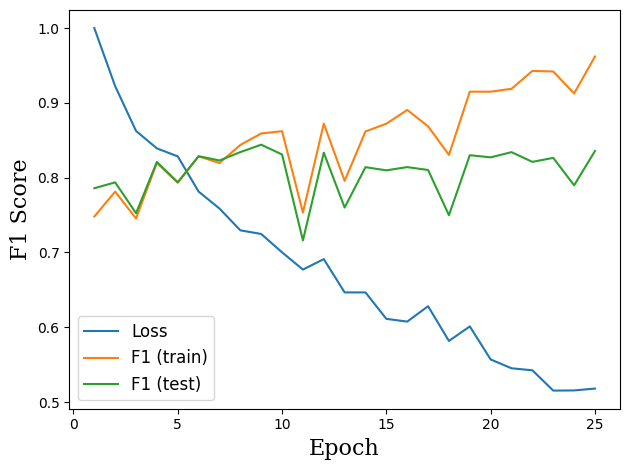

In [16]:
plot_training_results(results)

100%|██████████| 59/59 [00:15<00:00,  3.88it/s]


Evaluating model: bert_lstm.pth
F1 score for model: 0.844


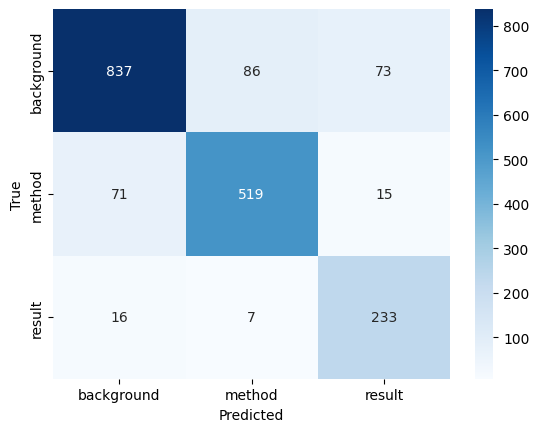

              precision    recall  f1-score   support

  background       0.91      0.84      0.87       996
      method       0.85      0.86      0.85       605
      result       0.73      0.91      0.81       256

    accuracy                           0.86      1857
   macro avg       0.83      0.87      0.84      1857
weighted avg       0.86      0.86      0.86      1857


In [17]:
model_path = 'bert_lstm.pth'

eval_model = torch.load(model_path)

y_true, y_pred = evaluate(eval_model, val_dataloader, device, is_f1=False)
label_list = ['background', 'method', 'result']

f1_eval = f1_score(y_true, y_pred, average='macro')
cm_eval = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=label_list)

print('Evaluating model: {}'.format(model_path))
print('F1 score for model: {:.3f}'.format(f1_eval))

sns.heatmap(cm_eval, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(report)